<a href="https://colab.research.google.com/github/henryfuentesbenito/TFM/blob/main/dNRI_Dimerization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Instalar bibliotecas necesarias
!pip install torch torchvision

In [ ]:
pip install andi_datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 5.0 MB/s eta 0:00:00


In [ ]:
# Clonar el repositorio
!git clone https://github.com/henryfuentesbenito/TFM.git

Cloning into 'TFM'...
remote: Enumerating objects: 509, done.
remote: Counting objects: 100% (271/271), done.
remote: Compressing objects: 100% (201/201), done.
remote: Total 509 (delta 80), reused 224 (delta 69), pack-reused 238 (from 1)
Receiving objects: 100% (509/509), 177.65 KiB | 17.76 MiB/s, done.
Resolving deltas: 100% (144/144), done.


In [ ]:
# Cambiar al directorio del repositorio clonado
%cd TFM

/content/TFM


In [ ]:
# Instalar cualquier otro requerimiento si es necesario
!pip install -e ./

Obtaining file:///content/TFM
  Preparing metadata (setup.py) ... done
  Running setup.py develop for dnri


In [ ]:
import os

# Definir las rutas
DATA_PATH = '/content/drive/MyDrive/datos_3_1000_50_128/'
BASE_RESULTS_DIR = '/content/drive/MyDrive/results1/'

In [ ]:
import os
import torch
# Ruta a los archivos en Google Drive
data_path = '/content/drive/MyDrive/datos_3_1000_50_128/'
train_feats_path = os.path.join(data_path, "train_feats")
train_edges_path = os.path.join(data_path, "train_edges")

# Cargar los datos
train_feats = torch.load(train_feats_path)
train_edges = torch.load(train_edges_path)

# Verificar dimensiones y contenido
print("Dimensiones de train_feats:", train_feats.shape)
print("Contenido de train_feats:")
print(train_feats[0])

print("Dimensiones de train_edges:", train_edges.shape)
print("Contenido de train_edges:")
print(train_edges[0])

Dimensiones de train_feats: torch.Size([1000, 50, 3, 2])
Contenido de train_feats:
tensor([[[169.2353,  27.8136],
         [159.6578,   7.8876],
         [143.0083, 163.6868]],

        [[168.8957,  30.2608],
         [159.8253,   8.0493],
         [144.4764, 162.9527]],

        [[167.6315,  29.7390],
         [160.8973,  10.1032],
         [146.4239, 163.6272]],

        [[169.3478,  30.8726],
         [160.6044,  11.6307],
         [147.0785, 163.4704]],

        [[167.0592,  30.1621],
         [161.6104,  13.1987],
         [143.2859, 163.3745]],

        [[165.4305,  27.3576],
         [161.4371,  15.9198],
         [140.7838, 161.0983]],

        [[166.3206,  28.2126],
         [160.3294,  16.1396],
         [141.2718, 160.6240]],

        [[167.1882,  28.3783],
         [157.8293,  17.8159],
         [140.4108, 160.1114]],

        [[166.6844,  28.2840],
         [155.5213,  18.8575],
         [142.3779, 158.1683]],

        [[166.3402,  26.7673],
         [156.3232,  18.6587],


<ipython-input-17-29b1dbd81e0d>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_feats = torch.load(train_feats_path)
<ipython-input-17-29b1dbd81e0d>:10: FutureWarning

In [ ]:
SEED=1

In [ ]:
WORKING_DIR=f"{BASE_RESULTS_DIR}nri/seed_{SEED}/"
ENCODER_ARGS='--num_edge_types 2 --encoder_hidden 256 --skip_first --encoder_mlp_hidden 256 --encoder_mlp_num_layers 3'
DECODER_ARGS=''
MODEL_ARGS=f"--model_type nri --graph_type static {ENCODER_ARGS} {DECODER_ARGS} --seed {SEED}"
TRAINING_ARGS='--no_edge_prior 0.9 --batch_size 16 --lr 5e-4 --use_adam --num_epochs 100 --lr_decay_factor 0.5
--lr_decay_steps 200 --normalize_kl --normalize_nll --tune_on_nll --val_teacher_forcing --teacher_forcing_steps -1'

In [ ]:
WORKING_DIR

'/content/drive/MyDrive/results1/nri/seed_1/'

In [ ]:
mkdir -p $WORKING_DIR

In [ ]:
from dnri.utils.flags import build_flags
import dnri.models.model_builder as model_builder
from dnri.datasets.small_synth_data import SmallSynthData
import dnri.training.train as train
import dnri.training.train_utils as train_utils
import dnri.training.evaluate as evaluate
import dnri.utils.misc as misc

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import torch

import os
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt, matplotlib.animation as animation, matplotlib.colors as mcolors
import numpy as np

def eval_edges(model, dataset, params):

    gpu = params.get('gpu', False)
    batch_size = params.get('batch_size', 1000)
    eval_metric = params.get('eval_metric')
    num_edge_types = params['num_edge_types']
    skip_first = params['skip_first']
    data_loader = DataLoader(dataset, batch_size=batch_size, pin_memory=gpu)
    full_edge_count = 0.
    model.eval()
    correct_edges = 0.
    edge_count = 0.
    correct_0_edges = 0.
    edge_0_count = 0.
    correct_1_edges = 0.
    edge_1_count = 0.

    correct = num_predicted = num_gt = 0
    all_edges = []
    for batch_ind, batch in enumerate(data_loader):
        inputs = batch['inputs']
        gt_edges = batch['edges'].long()
        with torch.no_grad():
            if gpu:
                inputs = inputs.cuda(non_blocking=True)
                gt_edges = gt_edges.cuda(non_blocking=True)

            _, _, _, edges, _ = model.calculate_loss(inputs, is_train=False, return_logits=True)
            edges = edges.argmax(dim=-1)
            all_edges.append(edges.cpu())
            if len(edges.shape) == 3 and len(gt_edges.shape) == 2:
                gt_edges = gt_edges.unsqueeze(1).expand(gt_edges.size(0), edges.size(1), gt_edges.size(1))
            elif len(gt_edges.shape) == 3 and len(edges.shape) == 2:
                edges = edges.unsqueeze(1).expand(edges.size(0), gt_edges.size(1), edges.size(1))
            if edges.size(1) == gt_edges.size(1) - 1:
                gt_edges = gt_edges[:, :-1]
            edge_count += edges.numel()
            full_edge_count += gt_edges.numel()
            correct_edges += ((edges == gt_edges)).sum().item()
            edge_0_count += (gt_edges == 0).sum().item()
            edge_1_count += (gt_edges == 1).sum().item()
            correct_0_edges += ((edges == gt_edges)*(gt_edges == 0)).sum().item()
            correct_1_edges += ((edges == gt_edges)*(gt_edges == 1)).sum().item()
            correct += (edges*gt_edges).sum().item()
            num_predicted += edges.sum().item()
            num_gt += gt_edges.sum().item()
    prec = correct / (num_predicted + 1e-8)
    rec = correct / (num_gt + 1e-8)
    f1 = 2*prec*rec / (prec+rec+1e-6)
    all_edges = torch.cat(all_edges)
    return f1, correct_edges / (full_edge_count + 1e-8), correct_0_edges / (edge_0_count + 1e-8), correct_1_edges / (edge_1_count + 1e-8), all_edges

def plot_sample(model, dataset, num_samples, params):
    gpu = params.get('gpu', False)
    batch_size = params.get('batch_size', 1)
    use_gt_edges = params.get('use_gt_edges')
    data_loader = DataLoader(dataset, batch_size=batch_size)
    model.eval()
    batch_count = 0
    all_errors = []
    burn_in_steps = 10
    forward_pred_steps = 40
    for batch_ind, batch in enumerate(data_loader):
        inputs = batch['inputs']
        gt_edges = batch.get('edges', None)
        with torch.no_grad():
            model_inputs = inputs[:, :burn_in_steps]
            gt_predictions = inputs[:, burn_in_steps:burn_in_steps+forward_pred_steps]
            if gpu:
                model_inputs = model_inputs.cuda(non_blocking=True)
                if gt_edges is not None and use_gt_edges:
                    gt_edges = gt_edges.cuda(non_blocking=True)
            if not use_gt_edges:
                gt_edges=None
            model_preds = model.predict_future(model_inputs, forward_pred_steps).cpu()
            #total_se += F.mse_loss(model_preds, gt_predictions).item()
            print("MSE: ", torch.nn.functional.mse_loss(model_preds, gt_predictions).item())
            batch_count += 1
        fig, ax = plt.subplots()
        unnormalized_preds = dataset.unnormalize(model_preds)
        unnormalized_gt = dataset.unnormalize(inputs)
        def update(frame):
            ax.clear()
            ax.plot(unnormalized_gt[0, frame, 0, 0], unnormalized_gt[0, frame, 0, 1], 'bo')
            ax.plot(unnormalized_gt[0, frame, 1, 0], unnormalized_gt[0, frame, 1, 1], 'ro')
            ax.plot(unnormalized_gt[0, frame, 2, 0], unnormalized_gt[0, frame, 2, 1], 'go')
            if frame >= burn_in_steps:
                tmp_fr = frame - burn_in_steps
                ax.plot(unnormalized_preds[0, tmp_fr, 0, 0], unnormalized_preds[0, tmp_fr, 0, 1], 'bo', alpha=0.5)
                ax.plot(unnormalized_preds[0, tmp_fr, 1, 0], unnormalized_preds[0, tmp_fr, 1, 1], 'ro', alpha=0.5)
                ax.plot(unnormalized_preds[0, tmp_fr, 2, 0], unnormalized_preds[0, tmp_fr, 2, 1], 'go', alpha=0.5)
            ax.set_xlim(-6, 6)
            ax.set_ylim(-6, 6)
        ani = animation.FuncAnimation(fig, update, interval=100, frames=burn_in_steps+forward_pred_steps)
        path = os.path.join(params['working_dir'], 'pred_trajectory_%d.mp4'%batch_ind)
        ani.save(path, codec='mpeg4')
        if batch_count >= num_samples:
            break

In [ ]:
import argparse

In [ ]:
parser = argparse.ArgumentParser('')
parser.add_argument('--working_dir', required=True)
parser.add_argument('--gpu', action='store_true')
parser.add_argument('--seed', type=int, default=1)
parser.add_argument('--mode', choices=['train', 'eval', 'eval_fixedwindow'], required=True)
parser.add_argument('--load_model')
parser.add_argument('--load_best_model', action='store_true')
parser.add_argument('--continue_training', action='store_true')
parser.add_argument('--model_type', choices=['nri', 'dnri', 'fc_baseline'])

# Training Params
parser.add_argument('--num_epochs', type=int)
parser.add_argument('--lr', type=float, default=1e-3)
parser.add_argument('--mom', type=float, default=0)
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--sub_batch_size', type=int)
parser.add_argument('--val_batch_size', type=int)
parser.add_argument('--val_interval', type=int, default=5)
parser.add_argument('--test', action='store_true')
parser.add_argument('--use_adam', action='store_true')
parser.add_argument('--lr_decay_factor', type=float)
parser.add_argument('--lr_decay_steps', type=int)
parser.add_argument('--clip_grad_norm', type=float)
parser.add_argument('--verbose', action='store_true')
parser.add_argument('--tune_on_nll', action='store_true')
parser.add_argument('--val_teacher_forcing', action='store_true')
parser.add_argument('--accumulate_steps', type=int, default=1)
parser.add_argument('--max_burn_in_count', type=int, default=-1)

# Model Params
parser.add_argument('--no_prior', action='store_true')
parser.add_argument('--avg_prior', action='store_true')
parser.add_argument('--add_uniform_prior', action='store_true')
parser.add_argument('--prior_num_layers', type=int, default=1)
parser.add_argument('--prior_hidden_size', type=int, default=256)
parser.add_argument('--use_learned_prior', action='store_true')
parser.add_argument('--graph_type', choices=['static', 'dynamic'])
parser.add_argument('--avg_encoder_inputs', action='store_true')
parser.add_argument('--use_dynamic_graph', action='store_true')
parser.add_argument('--use_static_encoder', action='store_true')
parser.add_argument('--decoder_type')
parser.add_argument('--encoder_rnn_type', choices=['lstm', 'gru'], default='lstm')
parser.add_argument('--decoder_rnn_type', choices=['lstm', 'gru'], default='gru')
parser.add_argument('--encoder_hidden', type=int, default=256)
parser.add_argument('--encoder_rnn_hidden', type=int)
parser.add_argument('--num_edge_types', type=int, default=2)
parser.add_argument('--encoder_dropout', type=float, default=0.0)
parser.add_argument('--encoder_unidirectional', action='store_true')
parser.add_argument('--encoder_bidirectional', action='store_true')
parser.add_argument('--encoder_no_factor', action='store_true', default=False)
parser.add_argument('--decoder_hidden', type=int, default=256)
parser.add_argument('--decoder_msg_hidden', type=int, default=256)
parser.add_argument('--decoder_dropout', type=float, default=0.0)
parser.add_argument('--skip_first', action='store_true', default=False)
parser.add_argument('--uniform_prior', action='store_true')
parser.add_argument('--no_edge_prior', type=float)
parser.add_argument('--teacher_forcing_steps', type=int, default=10)
parser.add_argument('--gumbel_temp', type=float, default=0.5)
parser.add_argument('--train_hard_sample', action='store_true')
parser.add_argument('--normalize_kl', action='store_true')
parser.add_argument('--normalize_kl_per_var', action='store_true')
parser.add_argument('--normalize_nll', action='store_true')
parser.add_argument('--normalize_nll_per_var', action='store_true')
parser.add_argument('--kl_coef', type=float, default=1.)
parser.add_argument('--no_encoder_bn', action='store_true')
parser.add_argument('--encoder_mlp_hidden', type=int, default=256)
parser.add_argument('--encoder_mlp_num_layers', type=int, default=1)
parser.add_argument('--rnn_hidden', type=int, default=64)
parser.add_argument('--teacher_forcing_prior', action='store_true')
parser.add_argument('--decoder_rnn_hidden', type=int)
parser.add_argument('--encoder_save_eval_memory', action='store_true')
parser.add_argument('--encoder_normalize_mode', choices=[None, 'normalize_inp', 'normalize_all'])
parser.add_argument('--normalize_inputs', action='store_true')
parser.add_argument('--data_path')
parser.add_argument('--same_data_norm', action='store_true')
parser.add_argument('--no_data_norm', action='store_true')
parser.add_argument('--error_out_name', default='prediction_errors_%dstep.npy')
parser.add_argument('--prior_variance', type=float, default=5e-5)
parser.add_argument('--test_burn_in_steps', type=int, default=10)
parser.add_argument('--error_suffix')
parser.add_argument('--subject_ind', type=int, default=-1)

_StoreAction(option_strings=['--subject_ind'], dest='subject_ind', nargs=None, const=None, default=-1, type=<class 'int'>, choices=None, required=False, help=None, metavar=None)

In [ ]:
args = parser.parse_args(f'--mode train --data_path {DATA_PATH} --working_dir {WORKING_DIR} {MODEL_ARGS} {TRAINING_ARGS}'.split()); args

Namespace(working_dir='/content/drive/MyDrive/results1/nri/seed_1/', gpu=False, seed=1, mode='train', load_model=None, load_best_model=False, continue_training=False, model_type='nri', num_epochs=100, lr=0.0005, mom=0, batch_size=16, sub_batch_size=None, val_batch_size=None, val_interval=5, test=False, use_adam=True, lr_decay_factor=0.5, lr_decay_steps=200, clip_grad_norm=None, verbose=False, tune_on_nll=True, val_teacher_forcing=True, accumulate_steps=1, max_burn_in_count=-1, no_prior=False, avg_prior=False, add_uniform_prior=False, prior_num_layers=1, prior_hidden_size=256, use_learned_prior=False, graph_type='static', avg_encoder_inputs=False, use_dynamic_graph=False, use_static_encoder=False, decoder_type=None, encoder_rnn_type='lstm', decoder_rnn_type='gru', encoder_hidden=256, encoder_rnn_hidden=None, num_edge_types=2, encoder_dropout=0.0, encoder_unidirectional=False, encoder_bidirectional=False, encoder_no_factor=False, decoder_hidden=256, decoder_msg_hidden=256, decoder_dropou

In [ ]:
params = vars(args);params

{'working_dir': '/content/drive/MyDrive/results1/nri/seed_1/',
 'gpu': False,
 'seed': 1,
 'mode': 'train',
 'load_model': None,
 'load_best_model': False,
 'continue_training': False,
 'model_type': 'nri',
 'num_epochs': 100,
 'lr': 0.0005,
 'mom': 0,
 'batch_size': 16,
 'sub_batch_size': None,
 'val_batch_size': None,
 'val_interval': 5,
 'test': False,
 'use_adam': True,
 'lr_decay_factor': 0.5,
 'lr_decay_steps': 200,
 'clip_grad_norm': None,
 'verbose': False,
 'tune_on_nll': True,
 'val_teacher_forcing': True,
 'accumulate_steps': 1,
 'max_burn_in_count': -1,
 'no_prior': False,
 'avg_prior': False,
 'add_uniform_prior': False,
 'prior_num_layers': 1,
 'prior_hidden_size': 256,
 'use_learned_prior': False,
 'graph_type': 'static',
 'avg_encoder_inputs': False,
 'use_dynamic_graph': False,
 'use_static_encoder': False,
 'decoder_type': None,
 'encoder_rnn_type': 'lstm',
 'decoder_rnn_type': 'gru',
 'encoder_hidden': 256,
 'encoder_rnn_hidden': None,
 'num_edge_types': 2,
 'encoder

In [ ]:
misc.seed(args.seed) # set seed for numpy torch cuda and random libs

In [ ]:
params['num_vars'] = 3
params['input_size'] = 2
params['input_time_steps'] = 50
params['nll_loss_type'] = 'gaussian'
train_data = SmallSynthData(args.data_path, 'train', params)
val_data   = SmallSynthData(args.data_path, 'val', params)

/content/TFM/dnri/datasets/small_synth_data.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.feats = torch.load(path)
/content/TFM/dnri/datasets/small_synth_data.py

In [ ]:
model = model_builder.build_model(params)

Using factor graph MLP encoder.
ENCODER:  RefMLPEncoder(
  (mlp1): RefNRIMLP(
    (model): Sequential(
      (0): Linear(in_features=100, out_features=256, bias=True)
      (1): ELU(alpha=1.0, inplace=True)
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=256, out_features=256, bias=True)
      (4): ELU(alpha=1.0, inplace=True)
    )
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (mlp2): RefNRIMLP(
    (model): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ELU(alpha=1.0, inplace=True)
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=256, out_features=256, bias=True)
      (4): ELU(alpha=1.0, inplace=True)
    )
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (mlp3): RefNRIMLP(
    (model): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ELU(alpha=1.0, inplace=True)
 

In [ ]:
params['gpu']

False

In [ ]:
if args.mode == 'train':
    with train_utils.build_writers(args.working_dir) as (train_writer, val_writer):
        train.train(model, train_data, val_data, params, train_writer, val_writer)

EPOCH 1 0
BEST VAL RESULT. SAVING MODEL...
EPOCH 1 EVAL: 
	CURRENT VAL LOSS: -0.368062
	BEST VAL LOSS:    -0.368062
	BEST VAL EPOCH:   1
EPOCH 2 18.47025156021118
BEST VAL RESULT. SAVING MODEL...
EPOCH 2 EVAL: 
	CURRENT VAL LOSS: -0.472866
	BEST VAL LOSS:    -0.472866
	BEST VAL EPOCH:   2
EPOCH 3 18.978795528411865
EPOCH 3 EVAL: 
	CURRENT VAL LOSS: -0.462731
	BEST VAL LOSS:    -0.472866
	BEST VAL EPOCH:   2
EPOCH 4 18.397271394729614
EPOCH 4 EVAL: 
	CURRENT VAL LOSS: -0.448044
	BEST VAL LOSS:    -0.472866
	BEST VAL EPOCH:   2
EPOCH 5 18.01591420173645
EPOCH 5 EVAL: 
	CURRENT VAL LOSS: -0.449879
	BEST VAL LOSS:    -0.472866
	BEST VAL EPOCH:   2
EPOCH 6 18.490074634552002
BEST VAL RESULT. SAVING MODEL...
EPOCH 6 EVAL: 
	CURRENT VAL LOSS: -0.480722
	BEST VAL LOSS:    -0.480722
	BEST VAL EPOCH:   6
EPOCH 7 18.414820671081543
EPOCH 7 EVAL: 
	CURRENT VAL LOSS: -0.450636
	BEST VAL LOSS:    -0.480722
	BEST VAL EPOCH:   6
EPOCH 8 19.049626350402832
EPOCH 8 EVAL: 
	CURRENT VAL LOSS: -0.454510
	B

In [ ]:
#if args.mode == 'eval':
test_data = SmallSynthData(args.data_path, 'test', params)
forward_pred = 50 - args.test_burn_in_steps
test_mse  = evaluate.eval_forward_prediction(model, test_data, args.test_burn_in_steps, forward_pred, params)
path = os.path.join(args.working_dir, args.error_out_name%args.test_burn_in_steps)
np.save(path, test_mse.cpu().numpy())
test_mse_1  = test_mse[0].item()
test_mse_15 = test_mse[14].item()
test_mse_25 = test_mse[24].item()
print("FORWARD PRED RESULTS:")
print("\t1 STEP: ", test_mse_1)
print("\t15 STEP: ",test_mse_15)
print("\t25 STEP: ",test_mse_25)


f1, all_acc, acc_0, acc_1, edges = eval_edges(model, val_data, params)
print("Val Edge results:")
print("\tF1: ",f1)
print("\tAll predicted edge accuracy: ",all_acc)
print("\tFirst Edge Acc: ",acc_0)
print("\tSecond Edge Acc: ",acc_1)
out_dir = os.path.join(args.working_dir, 'preds')
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, 'encoder_edges.npy')
np.save(out_path, edges.numpy())

plot_sample(model, test_data, args.test_burn_in_steps, params)

FORWARD PRED RESULTS:
	1 STEP:  0.00019445005455054343
	15 STEP:  0.0028454724233597517
	25 STEP:  0.004722208715975285
Val Edge results:
	F1:  0.0
	All predicted edge accuracy:  0.9502333333333016
	First Edge Acc:  0.9999999999999649
	Second Edge Acc:  0.0
MSE:  0.0037640701048076153
MSE:  0.00432803388684988
MSE:  0.004118225537240505
MSE:  0.0031722034327685833
MSE:  0.003790777875110507
MSE:  0.003124447073787451
MSE:  0.004346059635281563
MSE:  0.0042080567218363285
MSE:  0.004250859376043081
MSE:  0.0043562594801187515


In [ ]:
! --test_burn_in_steps 25

/bin/bash: line 1: --test_burn_in_steps: command not found


In [ ]:
args = parser.parse_args(f'--mode eval --test_burn_in_steps 25 --load_best_model --data_path {DATA_PATH} --working_dir {WORKING_DIR} {MODEL_ARGS} {TRAINING_ARGS}'.split()); args

Namespace(working_dir='/content/drive/MyDrive/results_1000/nri/seed_1/', gpu=False, seed=1, mode='eval', load_model=None, load_best_model=True, continue_training=False, model_type='nri', num_epochs=100, lr=0.0005, mom=0, batch_size=16, sub_batch_size=None, val_batch_size=None, val_interval=5, test=False, use_adam=True, lr_decay_factor=0.5, lr_decay_steps=200, clip_grad_norm=None, verbose=False, tune_on_nll=True, val_teacher_forcing=True, accumulate_steps=1, max_burn_in_count=-1, no_prior=False, avg_prior=False, add_uniform_prior=False, prior_num_layers=1, prior_hidden_size=256, use_learned_prior=False, graph_type='static', avg_encoder_inputs=False, use_dynamic_graph=False, use_static_encoder=False, decoder_type=None, encoder_rnn_type='lstm', decoder_rnn_type='gru', encoder_hidden=256, encoder_rnn_hidden=None, num_edge_types=2, encoder_dropout=0.0, encoder_unidirectional=False, encoder_bidirectional=False, encoder_no_factor=False, decoder_hidden=256, decoder_msg_hidden=256, decoder_drop

In [ ]:
params = vars(args);params

{'working_dir': '/content/drive/MyDrive/results_1000/nri/seed_1/',
 'gpu': False,
 'seed': 1,
 'mode': 'eval',
 'load_model': None,
 'load_best_model': True,
 'continue_training': False,
 'model_type': 'nri',
 'num_epochs': 100,
 'lr': 0.0005,
 'mom': 0,
 'batch_size': 16,
 'sub_batch_size': None,
 'val_batch_size': None,
 'val_interval': 5,
 'test': False,
 'use_adam': True,
 'lr_decay_factor': 0.5,
 'lr_decay_steps': 200,
 'clip_grad_norm': None,
 'verbose': False,
 'tune_on_nll': True,
 'val_teacher_forcing': True,
 'accumulate_steps': 1,
 'max_burn_in_count': -1,
 'no_prior': False,
 'avg_prior': False,
 'add_uniform_prior': False,
 'prior_num_layers': 1,
 'prior_hidden_size': 256,
 'use_learned_prior': False,
 'graph_type': 'static',
 'avg_encoder_inputs': False,
 'use_dynamic_graph': False,
 'use_static_encoder': False,
 'decoder_type': None,
 'encoder_rnn_type': 'lstm',
 'decoder_rnn_type': 'gru',
 'encoder_hidden': 256,
 'encoder_rnn_hidden': None,
 'num_edge_types': 2,
 'encod

In [ ]:
misc.seed(args.seed) # set seed for numpy torch cuda and random libs

In [ ]:
params['num_vars'] = 3
params['input_size'] = 2
params['input_time_steps'] = 50
params['nll_loss_type'] = 'gaussian'
train_data = SmallSynthData(args.data_path, 'train', params)
val_data   = SmallSynthData(args.data_path, 'val', params)

In [ ]:
model = model_builder.build_model(params)

Using factor graph MLP encoder.
ENCODER:  RefMLPEncoder(
  (mlp1): RefNRIMLP(
    (model): Sequential(
      (0): Linear(in_features=100, out_features=256, bias=True)
      (1): ELU(alpha=1.0, inplace=True)
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=256, out_features=256, bias=True)
      (4): ELU(alpha=1.0, inplace=True)
    )
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (mlp2): RefNRIMLP(
    (model): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ELU(alpha=1.0, inplace=True)
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=256, out_features=256, bias=True)
      (4): ELU(alpha=1.0, inplace=True)
    )
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (mlp3): RefNRIMLP(
    (model): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ELU(alpha=1.0, inplace=True)
 

In [ ]:
if args.mode == 'eval':
    test_data = SmallSynthData(args.data_path, 'test', params)
    forward_pred = 50 - args.test_burn_in_steps
    test_mse  = evaluate.eval_forward_prediction(model, test_data, args.test_burn_in_steps, forward_pred, params)
    path = os.path.join(args.working_dir, args.error_out_name%args.test_burn_in_steps)
    np.save(path, test_mse.cpu().numpy())
    test_mse_1  = test_mse[0].item()
    test_mse_15 = test_mse[14].item()
    test_mse_25 = test_mse[24].item()
    print("FORWARD PRED RESULTS:")
    print("\t1 STEP: ", test_mse_1)
    print("\t15 STEP: ",test_mse_15)
    print("\t25 STEP: ",test_mse_25)


    f1, all_acc, acc_0, acc_1, edges = eval_edges(model, val_data, params)
    print("Val Edge results:")
    print("\tF1: ",f1)
    print("\tAll predicted edge accuracy: ",all_acc)
    print("\tFirst Edge Acc: ",acc_0)
    print("\tSecond Edge Acc: ",acc_1)
    out_dir = os.path.join(args.working_dir, 'preds_eval_best_25')
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, 'encoder_edges.npy')
    np.save(out_path, edges.numpy())

    plot_sample(model, test_data, args.test_burn_in_steps, params)

FORWARD PRED RESULTS:
	1 STEP:  0.0001786235225154087
	15 STEP:  0.0025711969938129187
	25 STEP:  0.004185905680060387
Val Edge results:
	F1:  0.0
	All predicted edge accuracy:  0.9502333333333016
	First Edge Acc:  0.9999999999999649
	Second Edge Acc:  0.0
MSE:  0.003529307898133993
MSE:  0.004158763214945793
MSE:  0.003856903873383999
MSE:  0.0027447794564068317
MSE:  0.003594917943701148
MSE:  0.0029372877907007933
MSE:  0.004263527691364288
MSE:  0.004048086237162352
MSE:  0.003793267998844385
MSE:  0.00400570360943675
MSE:  0.003737184451892972


<ipython-input-17-30936ab70676>:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


MSE:  0.004326538182795048
MSE:  0.0039019654504954815
MSE:  0.0036658027675002813
MSE:  0.0040575722232460976
MSE:  0.003606787184253335
MSE:  0.0032398169860243797
MSE:  0.003094239393249154
MSE:  0.005457522347569466
MSE:  0.003349598729982972
MSE:  0.0033209624234586954
MSE:  0.003752193646505475
MSE:  0.004018888343125582
MSE:  0.004000757820904255
MSE:  0.003184375585988164


In [ ]:
if args.mode == 'record_predictions':
    model.eval()
    burn_in = args.test_burn_in_steps
    forward_pred = 50 - args.test_burn_in_steps
    test_data = SmallSynthData(args.data_path, 'test', params)
    if args.subject_ind == -1:
        val_data_loader = DataLoader(test_data, batch_size=params['batch_size'])
        all_predictions = []
        all_edges = []
        for batch_ind,batch in enumerate(val_data_loader):
            print("BATCH %d of %d"%(batch_ind+1, len(val_data_loader)))
            inputs = batch['inputs']
            if args.gpu:
                inputs = inputs.cuda(non_blocking=True)
            with torch.no_grad():
                predictions, edges = model.predict_future(inputs[:, :burn_in], forward_pred, return_edges=True, return_everything=True)
                all_predictions.append(predictions)
                all_edges.append(edges)
        if args.error_suffix is not None:
            out_path = os.path.join(args.working_dir, 'preds/', 'all_test_subjects_%s.npy'%args.error_suffix)
        else:
            out_path = os.path.join(args.working_dir, 'preds/', 'all_test_subjects.npy')

        predictions = torch.cat(all_predictions, dim=0)
        edges = torch.cat(all_edges, dim=0)

    else:
        data = test_data[args.subject_ind]
        inputs = data['inputs'].unsqueeze(0)
        if args.gpu:
            inputs = inputs.cuda(non_blocking=True)
        with torch.no_grad():
            predictions, edges = model.predict_future(inputs[:, :burn_in], forward_pred, return_edges=True, return_everything=True)
            predictions = predictions.squeeze(0)
            edges = edges.squeeze(0)
        out_path = os.path.join(args.working_dir, 'preds/', 'subject_%d.npy'%args.subject_ind)
    tmp_dir = os.path.join(args.working_dir, 'preds/')
    if not os.path.exists(tmp_dir):
        os.makedirs(tmp_dir)
    torch.save([predictions.cpu(), edges.cpu()], out_path)

**DNIR**

In [120]:
WORKING_DIR=f"{BASE_RESULTS_DIR}dnri/seed_{SEED}/"
ENCODER_ARGS="--encoder_hidden 256 --encoder_mlp_num_layers 3 --encoder_mlp_hidden 128 --encoder_rnn_hidden 64"
DECODER_ARGS="--decoder_hidden 256 --decoder_type ref_mlp"
HIDDEN_ARGS="--rnn_hidden 64"
PRIOR_ARGS="--use_learned_prior --prior_num_layers 3 --prior_hidden_size 128"
MODEL_ARGS=f"--model_type dnri --graph_type dynamic --skip_first --num_edge_types 2
{ENCODER_ARGS} {DECODER_ARGS} {HIDDEN_ARGS} {PRIOR_ARGS} --seed {SEED}"
TRAINING_ARGS='--add_uniform_prior --no_edge_prior 0.7 --batch_size 16 --lr 5e-4 --use_adam
--num_epochs 200 --lr_decay_factor 0.5 --lr_decay_steps 200 --normalize_kl --normalize_nll --tune_on_nll
--val_teacher_forcing --teacher_forcing_steps -1'

In [121]:
args = parser.parse_args(f'--mode train --data_path {DATA_PATH} --working_dir {WORKING_DIR} {MODEL_ARGS} {TRAINING_ARGS} --gpu'.split()); args

Namespace(working_dir='/content/drive/MyDrive/results1/dnri/seed_1/', gpu=True, seed=1, mode='train', load_model=None, load_best_model=False, continue_training=False, model_type='dnri', num_epochs=200, lr=0.0005, mom=0, batch_size=16, sub_batch_size=None, val_batch_size=None, val_interval=5, test=False, use_adam=True, lr_decay_factor=0.5, lr_decay_steps=200, clip_grad_norm=None, verbose=False, tune_on_nll=True, val_teacher_forcing=True, accumulate_steps=1, max_burn_in_count=-1, no_prior=False, avg_prior=False, add_uniform_prior=True, prior_num_layers=4, prior_hidden_size=128, use_learned_prior=True, graph_type='dynamic', avg_encoder_inputs=False, use_dynamic_graph=False, use_static_encoder=False, decoder_type='ref_mlp', encoder_rnn_type='lstm', decoder_rnn_type='gru', encoder_hidden=256, encoder_rnn_hidden=64, num_edge_types=2, encoder_dropout=0.0, encoder_unidirectional=False, encoder_bidirectional=False, encoder_no_factor=False, decoder_hidden=512, decoder_msg_hidden=256, decoder_dro

In [71]:
args = parser.parse_args(f'--mode train --data_path {DATA_PATH} --working_dir {WORKING_DIR} {MODEL_ARGS} {TRAINING_ARGS}'.split()); args

Namespace(working_dir='/content/drive/MyDrive/results1/dnri/seed_1/', gpu=False, seed=1, mode='train', load_model=None, load_best_model=False, continue_training=False, model_type='dnri', num_epochs=200, lr=0.0005, mom=0, batch_size=16, sub_batch_size=None, val_batch_size=None, val_interval=5, test=False, use_adam=True, lr_decay_factor=0.5, lr_decay_steps=200, clip_grad_norm=None, verbose=False, tune_on_nll=True, val_teacher_forcing=True, accumulate_steps=1, max_burn_in_count=-1, no_prior=False, avg_prior=False, add_uniform_prior=True, prior_num_layers=4, prior_hidden_size=128, use_learned_prior=True, graph_type='dynamic', avg_encoder_inputs=False, use_dynamic_graph=False, use_static_encoder=False, decoder_type='ref_mlp', encoder_rnn_type='lstm', decoder_rnn_type='gru', encoder_hidden=256, encoder_rnn_hidden=64, num_edge_types=2, encoder_dropout=0.0, encoder_unidirectional=False, encoder_bidirectional=False, encoder_no_factor=False, decoder_hidden=256, decoder_msg_hidden=256, decoder_dr

In [122]:
params = vars(args);params

{'working_dir': '/content/drive/MyDrive/results1/dnri/seed_1/',
 'gpu': True,
 'seed': 1,
 'mode': 'train',
 'load_model': None,
 'load_best_model': False,
 'continue_training': False,
 'model_type': 'dnri',
 'num_epochs': 200,
 'lr': 0.0005,
 'mom': 0,
 'batch_size': 16,
 'sub_batch_size': None,
 'val_batch_size': None,
 'val_interval': 5,
 'test': False,
 'use_adam': True,
 'lr_decay_factor': 0.5,
 'lr_decay_steps': 200,
 'clip_grad_norm': None,
 'verbose': False,
 'tune_on_nll': True,
 'val_teacher_forcing': True,
 'accumulate_steps': 1,
 'max_burn_in_count': -1,
 'no_prior': False,
 'avg_prior': False,
 'add_uniform_prior': True,
 'prior_num_layers': 4,
 'prior_hidden_size': 128,
 'use_learned_prior': True,
 'graph_type': 'dynamic',
 'avg_encoder_inputs': False,
 'use_dynamic_graph': False,
 'use_static_encoder': False,
 'decoder_type': 'ref_mlp',
 'encoder_rnn_type': 'lstm',
 'decoder_rnn_type': 'gru',
 'encoder_hidden': 256,
 'encoder_rnn_hidden': 64,
 'num_edge_types': 2,
 'enco

In [123]:
misc.seed(args.seed) # set seed for numpy torch cuda and random libs

In [124]:
params['num_vars'] = 3
params['input_size'] = 2
params['input_time_steps'] = 50
params['nll_loss_type'] = 'gaussian'
train_data = SmallSynthData(args.data_path, 'train', params)
val_data   = SmallSynthData(args.data_path, 'val', params)

/content/TFM/dnri/datasets/small_synth_data.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.feats = torch.load(path)
/content/TFM/dnri/datasets/small_synth_data.py

In [125]:
model = model_builder.build_model(params)

Using learned interaction net decoder.
USING NO EDGE PRIOR:  tensor([[[-0.3567, -1.2040]]], device='cuda:0')
dNRI MODEL:  DNRI(
  (encoder): DNRI_Encoder(
    (mlp1): RefNRIMLP(
      (model): Sequential(
        (0): Linear(in_features=2, out_features=256, bias=True)
        (1): ELU(alpha=1.0, inplace=True)
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=256, out_features=256, bias=True)
        (4): ELU(alpha=1.0, inplace=True)
      )
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp2): RefNRIMLP(
      (model): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): ELU(alpha=1.0, inplace=True)
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=256, out_features=256, bias=True)
        (4): ELU(alpha=1.0, inplace=True)
      )
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp3): Ref

In [126]:
params['gpu']

True

In [127]:
if args.mode == 'train':
    with train_utils.build_writers(args.working_dir) as (train_writer, val_writer):
        train.train(model, train_data, val_data, params, train_writer, val_writer)

EPOCH 1 0
BEST VAL RESULT. SAVING MODEL...
EPOCH 1 EVAL: 
	CURRENT VAL LOSS: -0.484199
	BEST VAL LOSS:    -0.484199
	BEST VAL EPOCH:   1
EPOCH 2 11.820839166641235
EPOCH 2 EVAL: 
	CURRENT VAL LOSS: -0.461351
	BEST VAL LOSS:    -0.484199
	BEST VAL EPOCH:   1
EPOCH 3 11.52490782737732
EPOCH 3 EVAL: 
	CURRENT VAL LOSS: -0.478217
	BEST VAL LOSS:    -0.484199
	BEST VAL EPOCH:   1
EPOCH 4 11.583863496780396
BEST VAL RESULT. SAVING MODEL...
EPOCH 4 EVAL: 
	CURRENT VAL LOSS: -0.490545
	BEST VAL LOSS:    -0.490545
	BEST VAL EPOCH:   4
EPOCH 5 11.509497165679932
BEST VAL RESULT. SAVING MODEL...
EPOCH 5 EVAL: 
	CURRENT VAL LOSS: -0.495764
	BEST VAL LOSS:    -0.495764
	BEST VAL EPOCH:   5
EPOCH 6 11.410351991653442
EPOCH 6 EVAL: 
	CURRENT VAL LOSS: -0.483890
	BEST VAL LOSS:    -0.495764
	BEST VAL EPOCH:   5
EPOCH 7 11.397940397262573
EPOCH 7 EVAL: 
	CURRENT VAL LOSS: -0.476722
	BEST VAL LOSS:    -0.495764
	BEST VAL EPOCH:   5
EPOCH 8 11.47929072380066
EPOCH 8 EVAL: 
	CURRENT VAL LOSS: -0.490063
	B

FORWARD PRED RESULTS:
	1 STEP:  0.0003155226877424866
	15 STEP:  0.01575886271893978
	25 STEP:  0.03963610902428627
Val Edge results:
	F1:  0.008692128729789745
	All predicted edge accuracy:  0.903027210884323
	First Edge Acc:  0.9495090812806484
	Second Edge Acc:  0.008606444505639901
MSE:  0.034318938851356506


<ipython-input-11-30936ab70676>:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


MSE:  0.03456564620137215
MSE:  0.03337867930531502
MSE:  0.031702544540166855
MSE:  0.036682289093732834
MSE:  0.03316526487469673
MSE:  0.03425239771604538
MSE:  0.038300421088933945
MSE:  0.03234962746500969
MSE:  0.031477127224206924


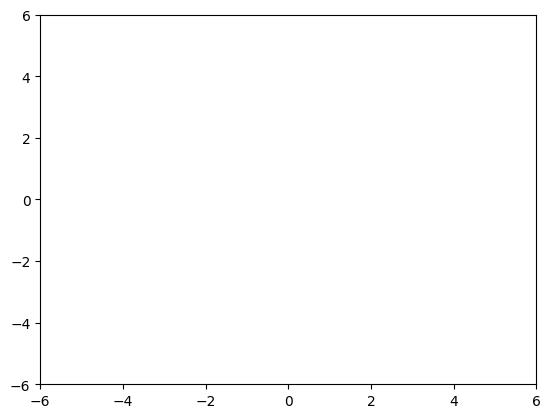

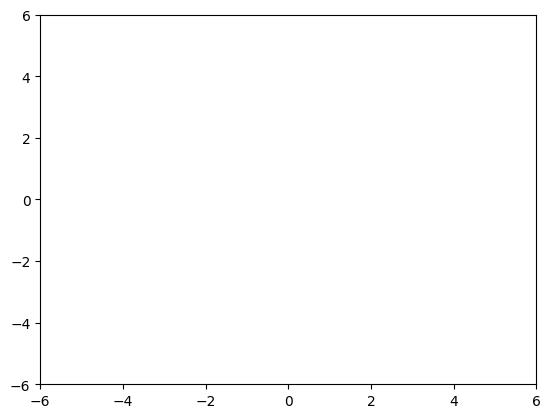

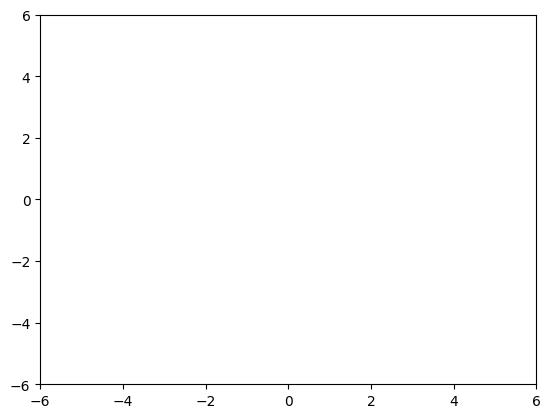

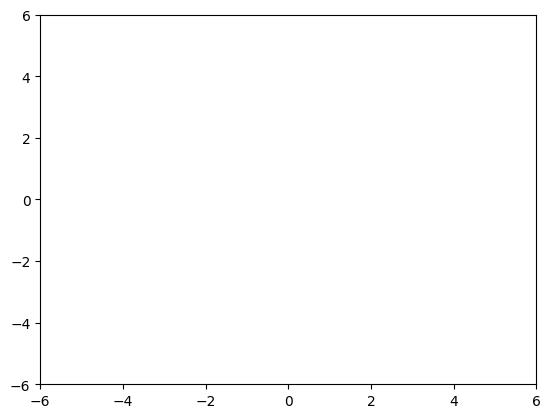

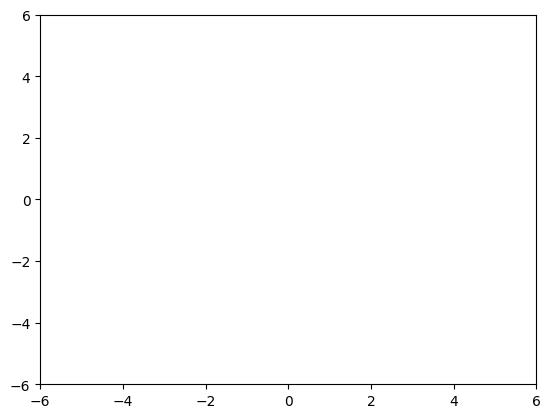

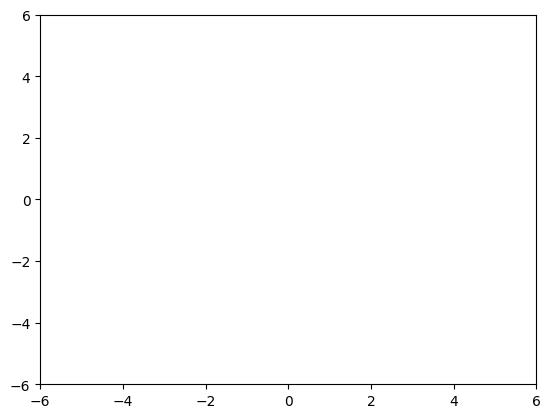

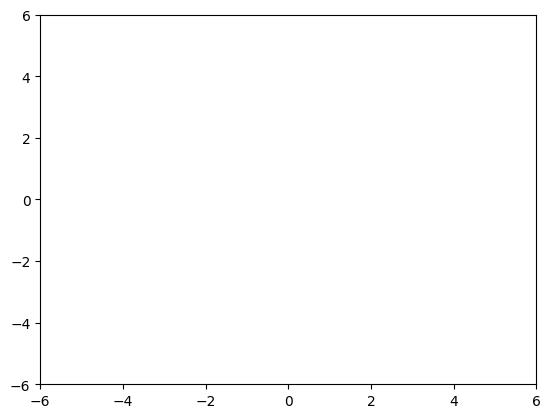

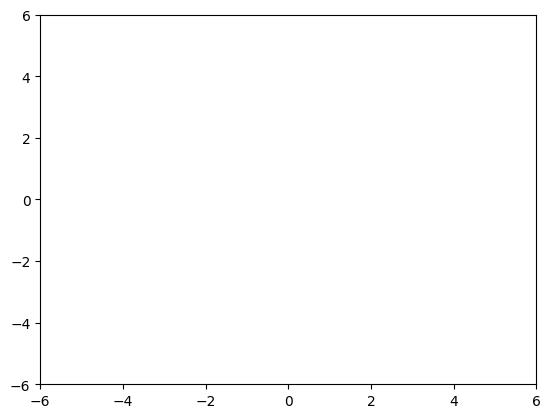

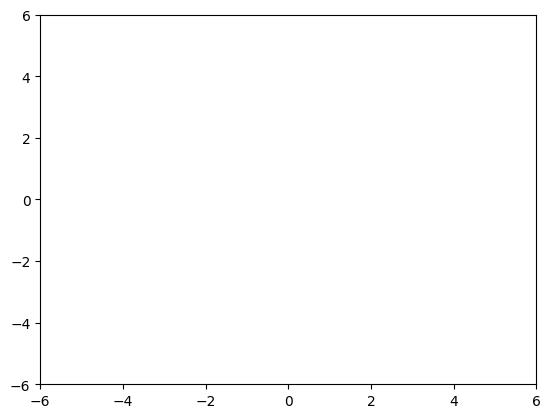

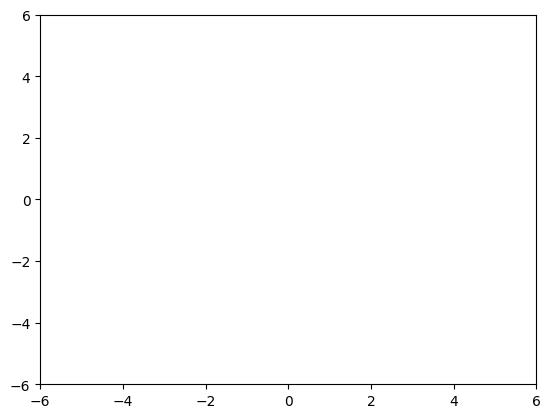

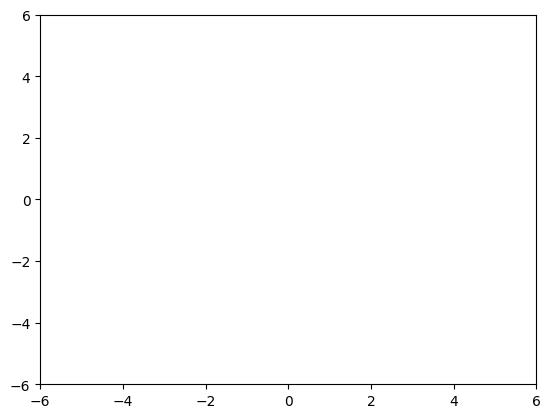

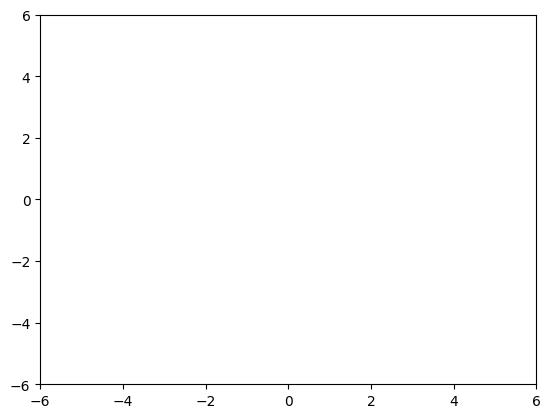

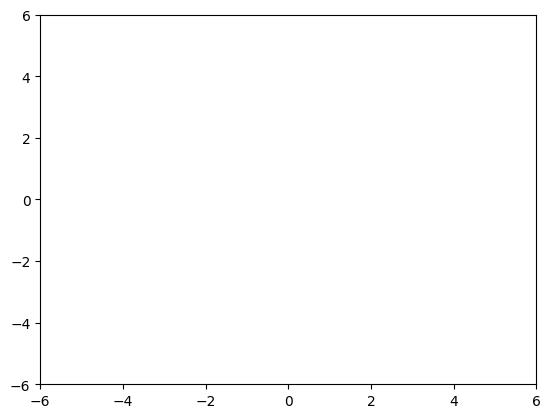

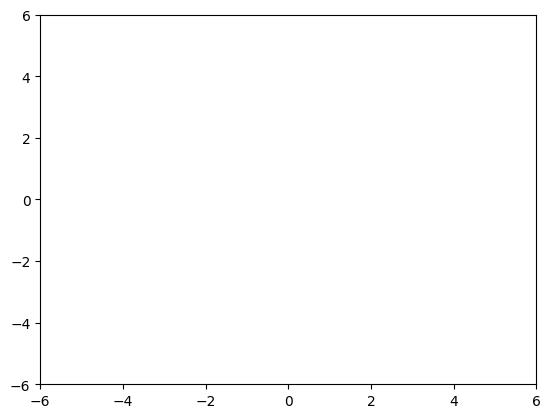

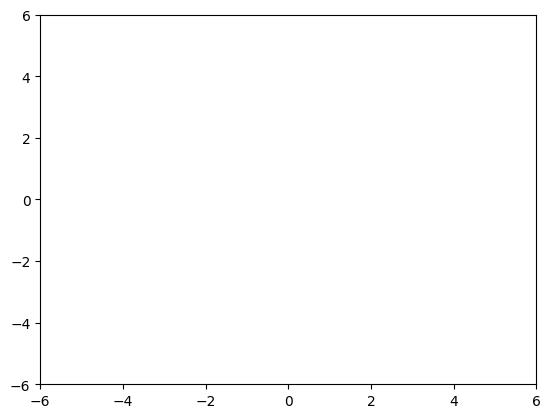

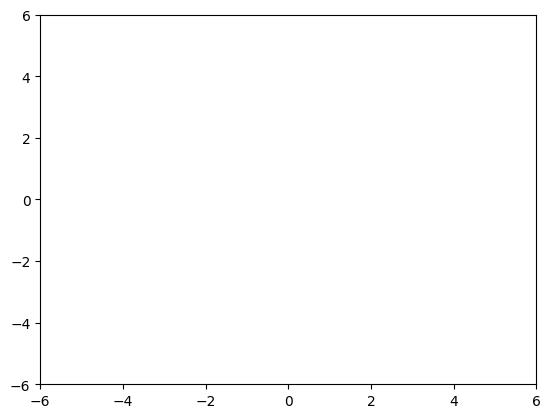

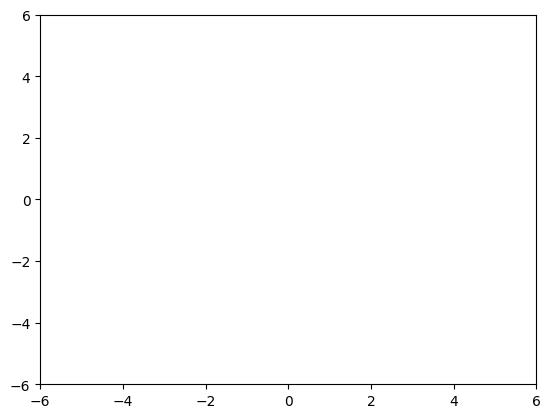

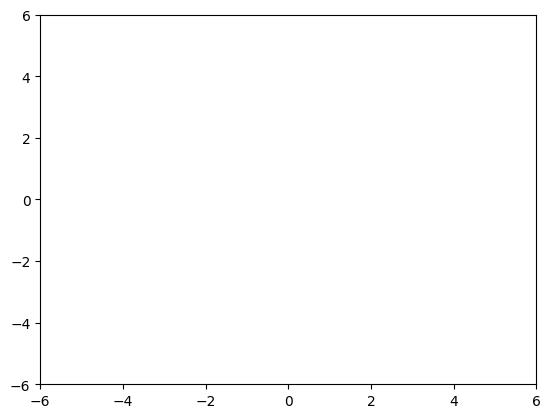

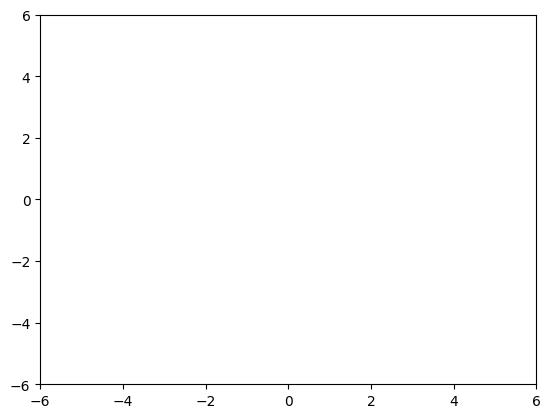

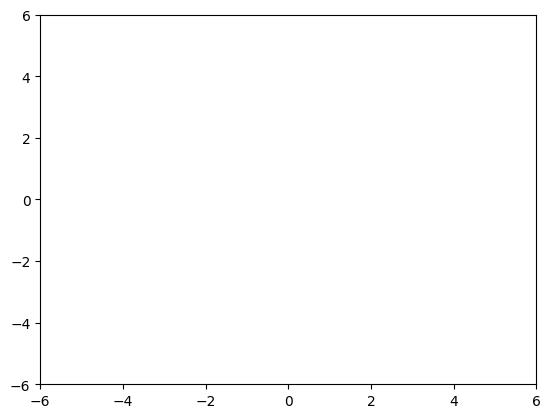

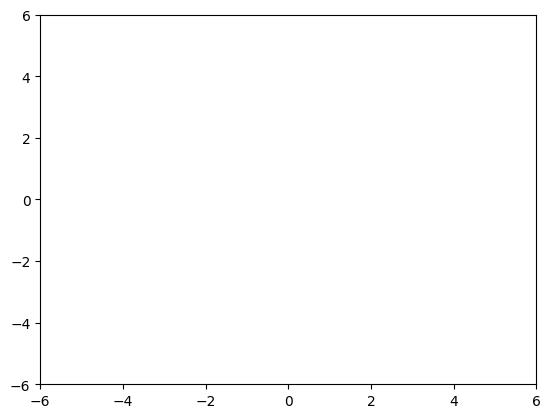

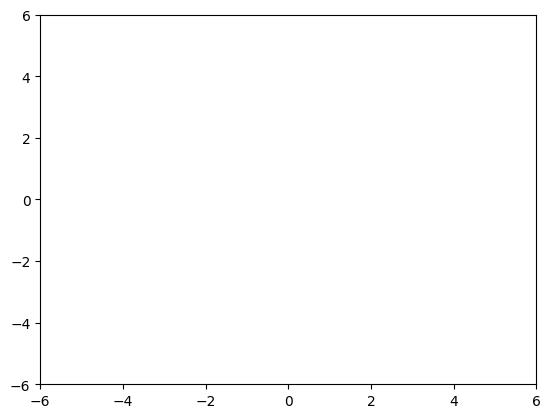

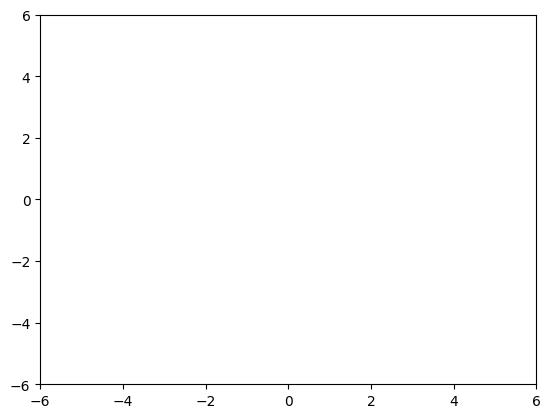

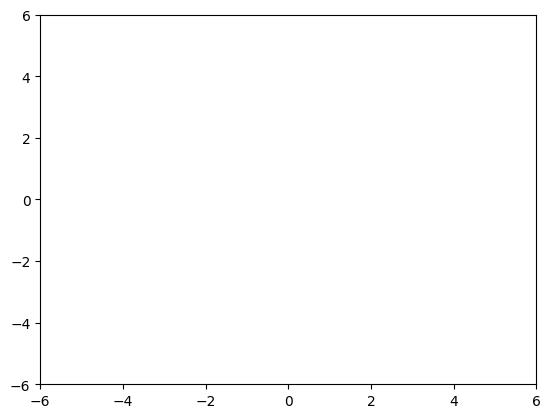

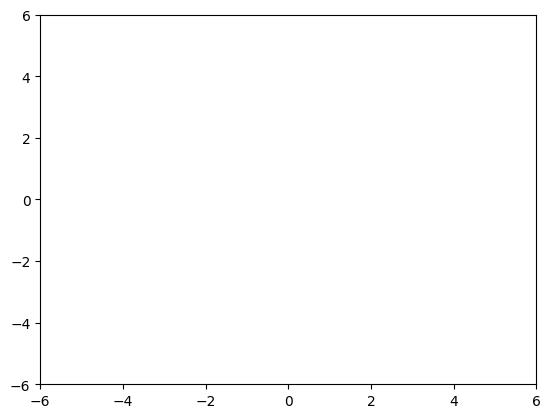

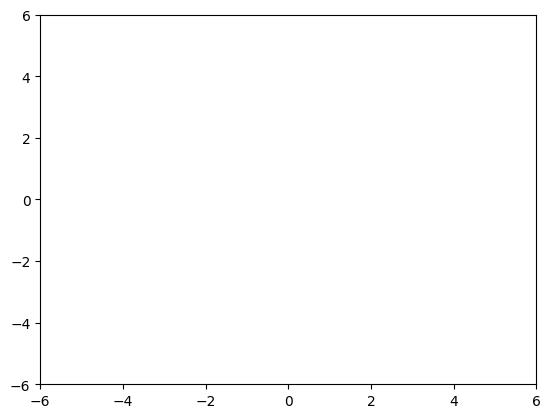

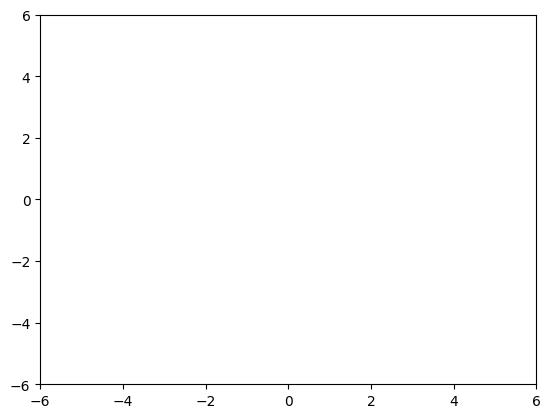

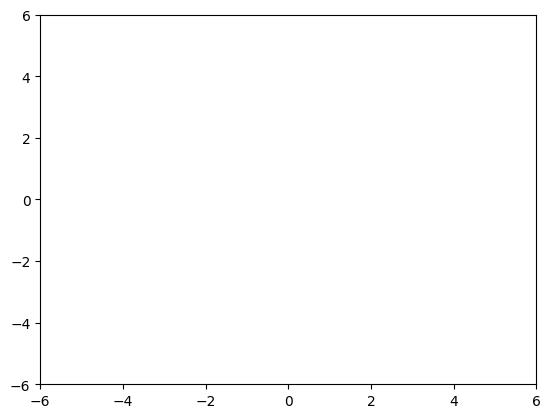

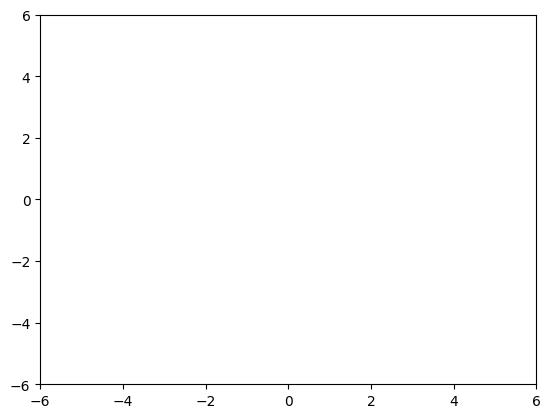

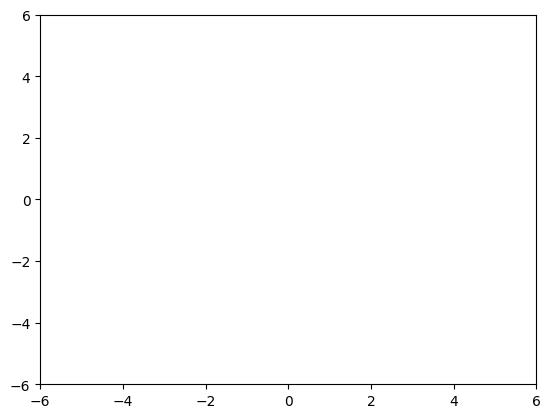

In [78]:
#if args.mode == 'eval':
test_data = SmallSynthData(args.data_path, 'test', params)
forward_pred = 50 - args.test_burn_in_steps
test_mse  = evaluate.eval_forward_prediction(model, test_data, args.test_burn_in_steps, forward_pred, params)
path = os.path.join(args.working_dir, args.error_out_name%args.test_burn_in_steps)
np.save(path, test_mse.cpu().numpy())
test_mse_1  = test_mse[0].item()
test_mse_15 = test_mse[14].item()
test_mse_25 = test_mse[24].item()
print("FORWARD PRED RESULTS:")
print("\t1 STEP: ", test_mse_1)
print("\t15 STEP: ",test_mse_15)
print("\t25 STEP: ",test_mse_25)


f1, all_acc, acc_0, acc_1, edges = eval_edges(model, val_data, params)
print("Val Edge results:")
print("\tF1: ",f1)
print("\tAll predicted edge accuracy: ",all_acc)
print("\tFirst Edge Acc: ",acc_0)
print("\tSecond Edge Acc: ",acc_1)
out_dir = os.path.join(args.working_dir, 'preds')
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, 'encoder_edges.npy')
np.save(out_path, edges.numpy())

plot_sample(model, test_data, args.test_burn_in_steps, params)

**Eval best**

In [128]:
args = parser.parse_args(f'--mode eval --load_best_model --data_path {DATA_PATH} --working_dir {WORKING_DIR} {MODEL_ARGS} {TRAINING_ARGS}'.split()); args

Namespace(working_dir='/content/drive/MyDrive/results1/dnri/seed_1/', gpu=False, seed=1, mode='eval', load_model=None, load_best_model=True, continue_training=False, model_type='dnri', num_epochs=200, lr=0.0005, mom=0, batch_size=16, sub_batch_size=None, val_batch_size=None, val_interval=5, test=False, use_adam=True, lr_decay_factor=0.5, lr_decay_steps=200, clip_grad_norm=None, verbose=False, tune_on_nll=True, val_teacher_forcing=True, accumulate_steps=1, max_burn_in_count=-1, no_prior=False, avg_prior=False, add_uniform_prior=True, prior_num_layers=4, prior_hidden_size=128, use_learned_prior=True, graph_type='dynamic', avg_encoder_inputs=False, use_dynamic_graph=False, use_static_encoder=False, decoder_type='ref_mlp', encoder_rnn_type='lstm', decoder_rnn_type='gru', encoder_hidden=256, encoder_rnn_hidden=64, num_edge_types=2, encoder_dropout=0.0, encoder_unidirectional=False, encoder_bidirectional=False, encoder_no_factor=False, decoder_hidden=512, decoder_msg_hidden=256, decoder_drop

In [129]:
params = vars(args);params

{'working_dir': '/content/drive/MyDrive/results1/dnri/seed_1/',
 'gpu': False,
 'seed': 1,
 'mode': 'eval',
 'load_model': None,
 'load_best_model': True,
 'continue_training': False,
 'model_type': 'dnri',
 'num_epochs': 200,
 'lr': 0.0005,
 'mom': 0,
 'batch_size': 16,
 'sub_batch_size': None,
 'val_batch_size': None,
 'val_interval': 5,
 'test': False,
 'use_adam': True,
 'lr_decay_factor': 0.5,
 'lr_decay_steps': 200,
 'clip_grad_norm': None,
 'verbose': False,
 'tune_on_nll': True,
 'val_teacher_forcing': True,
 'accumulate_steps': 1,
 'max_burn_in_count': -1,
 'no_prior': False,
 'avg_prior': False,
 'add_uniform_prior': True,
 'prior_num_layers': 4,
 'prior_hidden_size': 128,
 'use_learned_prior': True,
 'graph_type': 'dynamic',
 'avg_encoder_inputs': False,
 'use_dynamic_graph': False,
 'use_static_encoder': False,
 'decoder_type': 'ref_mlp',
 'encoder_rnn_type': 'lstm',
 'decoder_rnn_type': 'gru',
 'encoder_hidden': 256,
 'encoder_rnn_hidden': 64,
 'num_edge_types': 2,
 'encod

In [130]:
misc.seed(args.seed) # set seed for numpy torch cuda and random libs

In [131]:
params['num_vars'] = 3
params['input_size'] = 2
params['input_time_steps'] = 50
params['nll_loss_type'] = 'gaussian'
train_data = SmallSynthData(args.data_path, 'train', params)
val_data   = SmallSynthData(args.data_path, 'val', params)

In [132]:
model = model_builder.build_model(params)

Using learned interaction net decoder.
USING NO EDGE PRIOR:  tensor([[[-0.3567, -1.2040]]])
dNRI MODEL:  DNRI(
  (encoder): DNRI_Encoder(
    (mlp1): RefNRIMLP(
      (model): Sequential(
        (0): Linear(in_features=2, out_features=256, bias=True)
        (1): ELU(alpha=1.0, inplace=True)
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=256, out_features=256, bias=True)
        (4): ELU(alpha=1.0, inplace=True)
      )
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp2): RefNRIMLP(
      (model): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): ELU(alpha=1.0, inplace=True)
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=256, out_features=256, bias=True)
        (4): ELU(alpha=1.0, inplace=True)
      )
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp3): RefNRIMLP(
      (mo

/content/TFM/dnri/models/dnri.py:264: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


FORWARD PRED RESULTS:
	1 STEP:  0.0002538214612286538
	15 STEP:  0.0037601792719215155
	25 STEP:  0.006325786467641592
Val Edge results:
	F1:  0.1036721758325627
	All predicted edge accuracy:  0.6852823129251467
	First Edge Acc:  0.7017489873906632
	Second Edge Acc:  0.3684246763974329
MSE:  0.004847889766097069
MSE:  0.0062938714399933815
MSE:  0.005728584714233875
MSE:  0.0042013367637991905
MSE:  0.005270914174616337
MSE:  0.004211150575429201
MSE:  0.00572716910392046
MSE:  0.006478469353169203
MSE:  0.00534743582829833
MSE:  0.005675665568560362


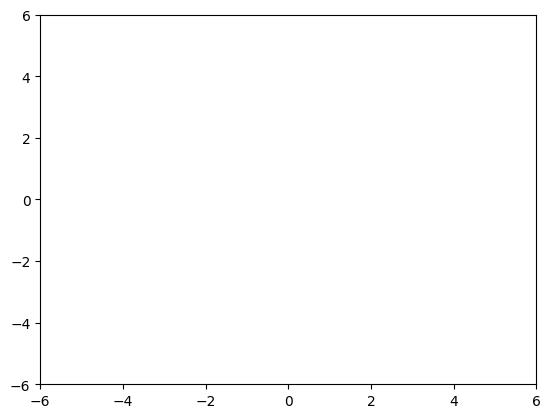

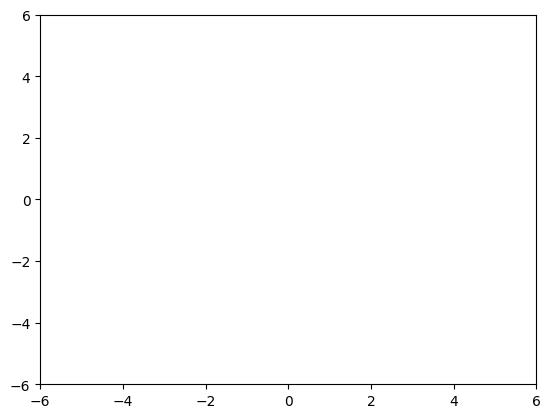

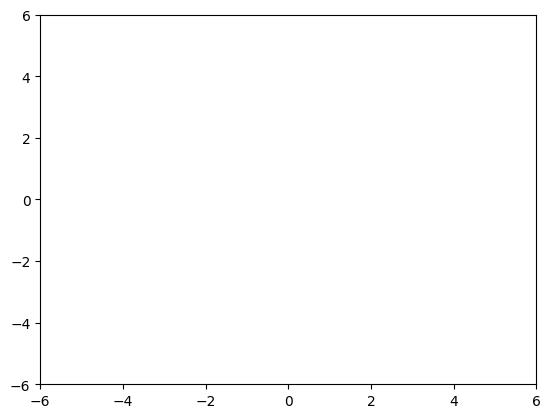

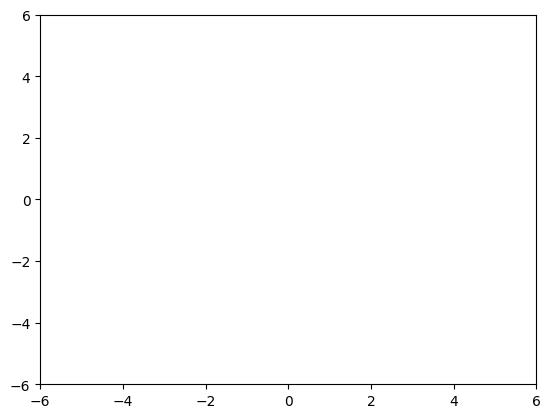

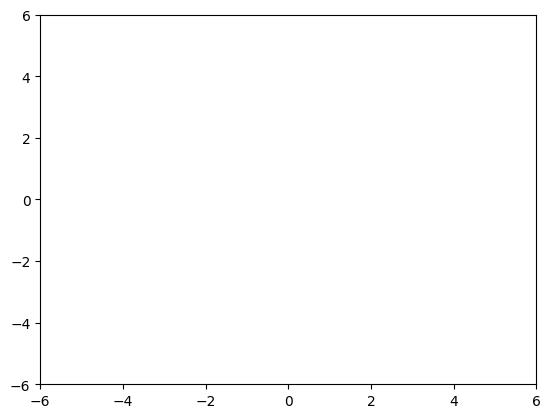

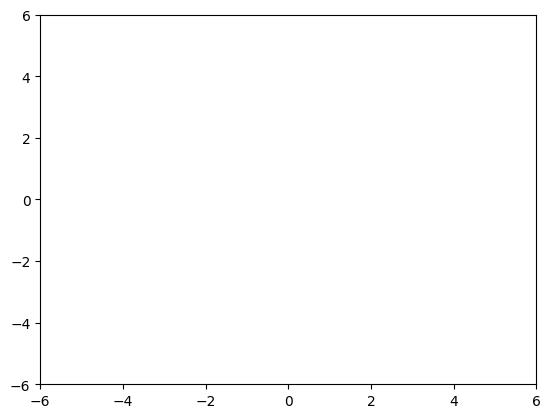

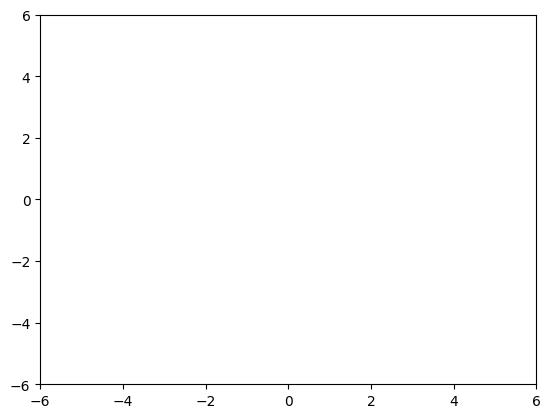

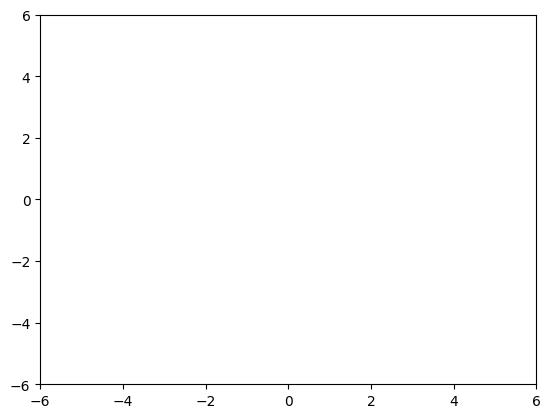

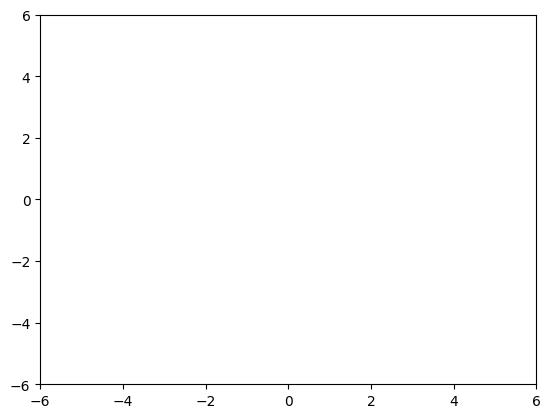

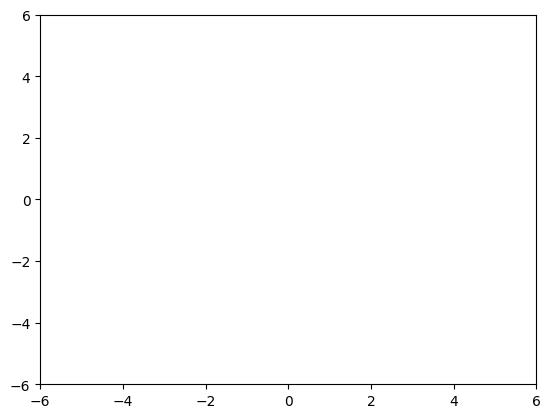

In [133]:
if args.mode == 'eval':
    test_data = SmallSynthData(args.data_path, 'test', params)
    forward_pred = 50 - args.test_burn_in_steps
    test_mse  = evaluate.eval_forward_prediction(model, test_data, args.test_burn_in_steps, forward_pred, params)
    path = os.path.join(args.working_dir, args.error_out_name%args.test_burn_in_steps)
    np.save(path, test_mse.cpu().numpy())
    test_mse_1  = test_mse[0].item()
    test_mse_15 = test_mse[14].item()
    test_mse_25 = test_mse[24].item()
    print("FORWARD PRED RESULTS:")
    print("\t1 STEP: ", test_mse_1)
    print("\t15 STEP: ",test_mse_15)
    print("\t25 STEP: ",test_mse_25)


    f1, all_acc, acc_0, acc_1, edges = eval_edges(model, val_data, params)
    print("Val Edge results:")
    print("\tF1: ",f1)
    print("\tAll predicted edge accuracy: ",all_acc)
    print("\tFirst Edge Acc: ",acc_0)
    print("\tSecond Edge Acc: ",acc_1)
    out_dir = os.path.join(args.working_dir, 'preds')
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, 'encoder_edges.npy')
    np.save(out_path, edges.numpy())

    plot_sample(model, test_data, args.test_burn_in_steps, params)

**Manual inspection of best model DNRI**

In [134]:
!pip install dnri  # Make sure the dnri package is installed

import dnri  # Import the dnri module

In [135]:
model = dnri.models.dnri.DNRI(params)

Using learned interaction net decoder.
USING NO EDGE PRIOR:  tensor([[[-0.3567, -1.2040]]])


In [136]:
path

'/content/drive/MyDrive/results1/dnri/seed_1/prediction_errors_10step.npy'

In [137]:
print("LOADING BEST MODEL")
path = os.path.join("/content/drive/MyDrive/results1/dnri/seed_1/", 'best_model')
print(path)
model.load(path)

LOADING BEST MODEL
/content/drive/MyDrive/results1/dnri/seed_1/best_model


/content/TFM/dnri/models/dnri.py:264: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


In [138]:
model

DNRI(
  (encoder): DNRI_Encoder(
    (mlp1): RefNRIMLP(
      (model): Sequential(
        (0): Linear(in_features=2, out_features=256, bias=True)
        (1): ELU(alpha=1.0, inplace=True)
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=256, out_features=256, bias=True)
        (4): ELU(alpha=1.0, inplace=True)
      )
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp2): RefNRIMLP(
      (model): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): ELU(alpha=1.0, inplace=True)
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=256, out_features=256, bias=True)
        (4): ELU(alpha=1.0, inplace=True)
      )
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp3): RefNRIMLP(
      (model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ELU(alph

In [139]:
args.data_path

'/content/drive/MyDrive/datos_3_1000_50_128/'

In [140]:
test_data = SmallSynthData(args.data_path, 'test', params)

/content/TFM/dnri/datasets/small_synth_data.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.feats = torch.load(path)
/content/TFM/dnri/datasets/small_synth_data.py

In [141]:
edges_true = torch.load(args.data_path+'test_edges')

<ipython-input-141-818d79b49168>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  edges_true = torch.load(args.data_path+'test_edges')


In [142]:
edges_true = torch.load(args.data_path+'val_edges')

<ipython-input-142-100786990366>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  edges_true = torch.load(args.data_path+'val_edges')


In [143]:
feats = torch.load(args.data_path+'test_feats')

<ipython-input-143-920cc02d58ed>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feats = torch.load(args.data_path+'test_feats')


In [144]:
feats = torch.load(args.data_path+'val_feats')

<ipython-input-144-e97cac2012a2>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feats = torch.load(args.data_path+'val_feats')


In [145]:
loc_max = feats[:, :, :, :2].max()
loc_min = feats[:, :, :, :2].min()
feats[:, :, :, :2] = (feats[:, :, :, :2] - loc_min) * 2 / (loc_max - loc_min) - 1

In [146]:
import torch.nn.functional as F

In [147]:
with torch.no_grad():
    inputs = feats # B, T, N, F

    # Encode input = predict prior and edge class
    sinputs = inputs[:, :-1]   # B,T-1,N,F
    prior_logits, posterior_logits, prior_state = model.encoder(sinputs)

    # Decode = predict next timestep features
    hidden = model.decoder.get_initial_hidden(inputs) # zeros B,N,H
    timesteps = inputs.size(1)  # T
    edges, predictions = [], []

    for step in range(timesteps - 1): # T-1
        dinput = inputs[:, step]  # B, N, F
        prediction, hidden, edge = model.single_step_forward(
            dinput,  # B, N, F
            hidden,  # B, N, H
            posterior_logits[:, step],  # B, E, C
            hard_sample=not model.training,
        )
        predictions.append(prediction)  # B, N, F
        edges.append(edge)              # B, E, C

    predictions = torch.stack(predictions, dim=1) # B, T-1, N, F
    target = inputs[:, 1:]  # [B:batch, T:time-1, N:num_object, F:num_feats] target the future

    # get loss
    # reconstruction
    loss_nll = model.nll_gaussian(predictions, target)

    # priors
    # learned prior
    prob = F.softmax(posterior_logits, dim=-1)
    loss_kl_learned = model.kl_categorical_learned(prob, prior_logits)
    # uniform (or guessed) prior
    loss_kl_uniform = model.kl_categorical_avg(prob)

    loss_kl = 0.5 * loss_kl_learned + 0.5 * loss_kl_uniform

    loss = loss_nll + model.kl_coef * loss_kl
    loss = loss.mean().item()

In [148]:
loss, loss_nll.mean(), loss_kl.mean(), loss_kl_uniform.mean(), loss_kl_learned.mean()

(-1.1463459730148315,
 tensor(-1.3149),
 tensor(0.1686),
 tensor(0.0579),
 tensor(0.2793))

In [149]:
F.mse_loss(predictions, target).item()

0.000135893962578848

In [150]:
from sklearn.metrics import f1_score

In [151]:
edges = torch.stack(edges).transpose(1,0)

In [152]:
sum(torch.argmax(edges,dim=-1).to(int).numpy().reshape(-1,6)==1)

array([21630, 15854, 21454, 15576,  8920,  8926])

In [153]:
sum(edges_true[:,1:].to(bool).numpy().reshape(-1,6)==1)

array([14930,     0,     0,     0,     0,     0])

In [154]:
edges_true_ = edges_true[:,1:].long()
edges_pred  = edges.argmax(dim=-1).long()

In [155]:
edges_true_.shape, edges_pred.shape, edges_true_.dtype, edges_pred.dtype

(torch.Size([1000, 49, 6]),
 torch.Size([1000, 49, 6]),
 torch.int64,
 torch.int64)

In [156]:
(f1_score(edges_true_.numpy().reshape(-1,6)[:,1],edges_pred.numpy().reshape(-1,6)[:,1],)
 +
 f1_score(edges_true_.numpy().reshape(-1,6)[:,3],edges_pred.numpy().reshape(-1,6)[:,3],)
)/2

0.0

In [157]:
edge_count = edges_pred.numel()
full_edge_count = edges_true_.numel()
correct_edges = ((edges_pred == edges_true_)).sum().item()
edge_0_count = (edges_true_ == 0).sum().item()
edge_1_count = (edges_true_ == 1).sum().item()
correct_0_edges = ((edges_pred == edges_true_)*(edges_true_ == 0)).sum().item()
correct_1_edges = ((edges_pred == edges_true_)*(edges_true_ == 1)).sum().item()
correct = (edges_pred*edges_true_).sum().item()
num_predicted = edges_pred.sum().item()
num_gt = edges_true_.sum().item()
prec = correct / (num_predicted + 1e-8)
rec = correct / (num_gt + 1e-8)
f1 = 2*prec*rec / (prec+rec+1e-6)
print(f1, correct_edges / (full_edge_count + 1e-8), correct_0_edges / (edge_0_count + 1e-8), correct_1_edges / (edge_1_count + 1e-8))

0.11104459218229333 0.6755918367346708 0.6903895080087186 0.3989953114531822


In [158]:
# see accuracy compared with data class percentages
1-edges_true.mean(), correct_edges / (full_edge_count + 1e-8)
# total accuracy is slightly better than percentage of edges

(tensor(0.9502), 0.6755918367346708)

**Prior**

In [159]:
prior_logits.shape

torch.Size([1000, 49, 6, 2])

In [160]:
edges_prior  = prior_logits.cpu().detach()
edges_logits = posterior_logits.cpu().detach()

In [161]:
import numpy as np
ep = np.argmax(edges_prior, axis=-1)
ec = np.argmax(edges_logits, axis=-1)

In [162]:
el = torch.nn.functional.gumbel_softmax(edges_logits, tau=model.gumbel_temp/2, hard=True,).cpu().numpy()

In [163]:
edges_t = edges_true_

In [164]:
edges_t.shape, ep.shape, ec.shape, el.shape

(torch.Size([1000, 49, 6]),
 torch.Size([1000, 49, 6]),
 torch.Size([1000, 49, 6]),
 (1000, 49, 6, 2))

In [165]:
edges_t[0]

tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0,

In [166]:
%matplotlib inline

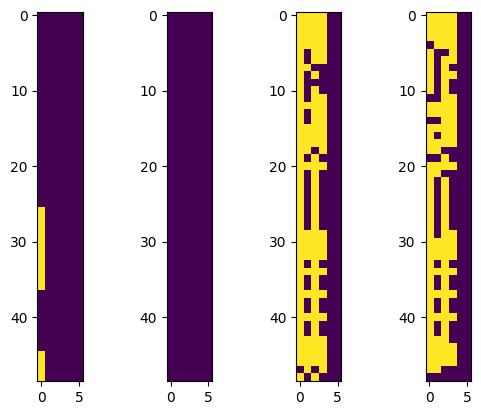

In [167]:
i=200
plt.subplot(141)
plt.imshow(edges_t[i].cpu().numpy())

plt.subplot(142)
plt.imshow(ep[i])

plt.subplot(143)
plt.imshow(ec[i]);
plt.subplot(144)
plt.imshow(el[i,...,1]);

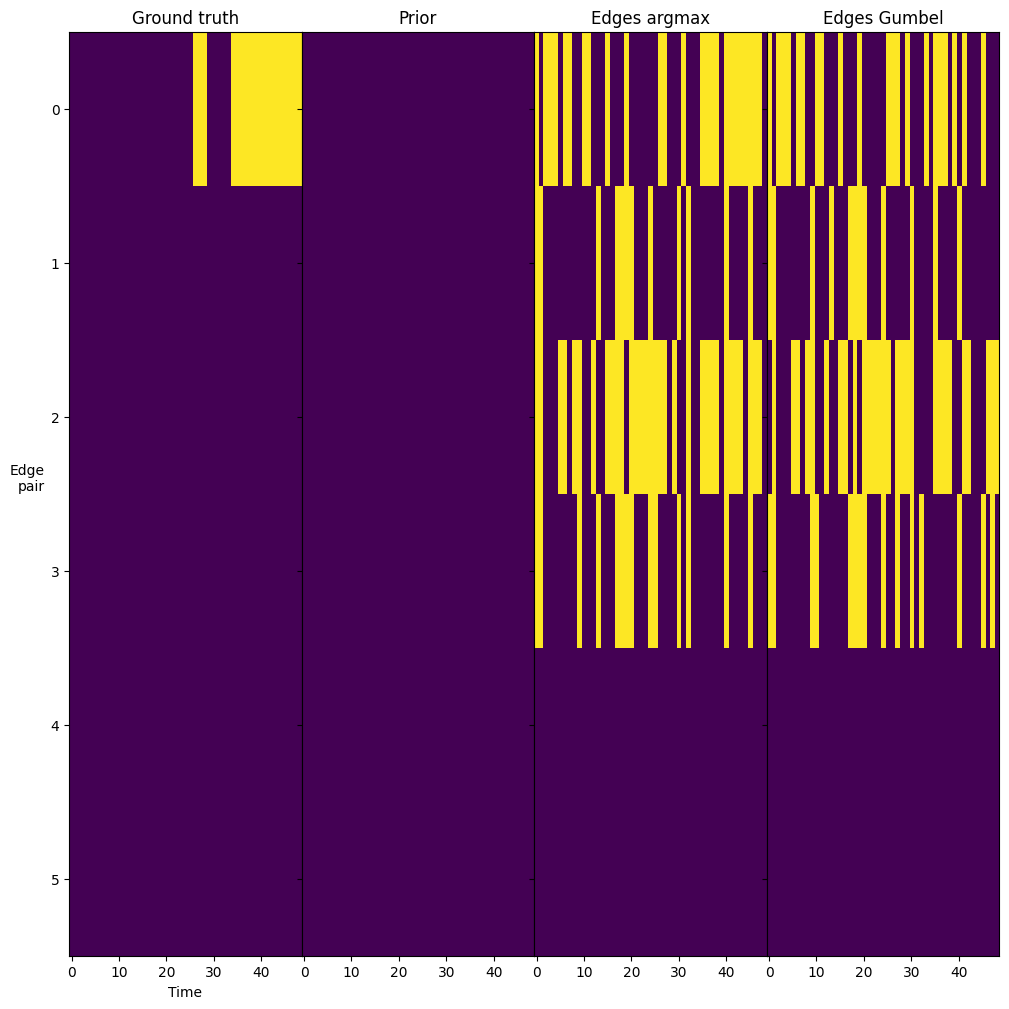

In [168]:
i=3 # timeseries sample
fig, axs = plt.subplots(1,4, sharey=True,
                        figsize=(12,12), gridspec_kw=dict(wspace=0))
axs[0].imshow(edges_t[i,].cpu().numpy().T,aspect='auto', vmin=0,vmax=1)
axs[0].set_xlabel('Time'); axs[0].set_ylabel('Edge\npair', rotation=0, ha='right')
axs[0].set_title('Ground truth')

axs[1].imshow(ep[i].T,aspect='auto', vmin=0,vmax=1)
axs[1].set_title('Prior')

axs[2].imshow(ec[i].T,aspect='auto', vmin=0,vmax=1);
axs[2].set_title('Edges argmax')

axs[3].imshow(el[i,...,1].T,aspect='auto', vmin=0,vmax=1);
axs[3].set_title('Edges Gumbel');